In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.__version__

NameError: name 'tf' is not defined

In [1]:
import os
import numpy as np
# !pip install Pillow
from PIL import Image
# !pip install scikit-learn
from sklearn.preprocessing import OneHotEncoder
# !pip install matplotlib
import matplotlib
from matplotlib import pyplot as plt
# !pip install tqdm
from tqdm import tqdm
# !pip install pandas
import pandas as pd
# !pip install opencv-python-headless
# import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# !pip install keras
# !pip install tensorflow
# !pip install tensorflow-macos
# !pip install tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, backend
from tensorflow.keras.optimizers import Adam, legacy

In [3]:
### load in all the CSV's for each ICH

## THIS IS THE CORRECT WAY THAT WE NEED TO TRY, NOT LOADING FROM IMG DIRECTORY

EDH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv') 
EDH_df = EDH_df[['Origin', 'Combined Label', 'Labeling State']]

print(EDH_df.columns)
EDH_labeled = EDH_df[EDH_df['Labeling State'] != 'In Progress']
EDH_valid_df = EDH_labeled[EDH_labeled['Correct Label'].notna()]

IVH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Brain Hemorrhage Tracing_2020-09-28_15.21.52.597.csv') # IVH
IVH_df = IVH_df[['Origin', 'Number of ROIs', 'Labeling State']]

print(IVH_df.columns)
IVH_labeled = IVH_df[IVH_df['Labeling State'] != 'In Progress']
IVH_valid_df = IVH_labeled[IVH_labeled['Number of ROIs'] != 0]

IPH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv')
IPH_df = IPH_df[['Origin', 'Correct Label', 'Labeling State']]

print(IPH_df.columns)
IPH_labeled = IPH_df[IPH_df['Labeling State'] != 'In Progress']
IPH_valid_df = IPH_labeled[IPH_labeled['Correct Label'].notna()]

SDH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Subdural Hemorrhage Detection_2020-11-16_21.37.19.745.csv')
SDH_df = SDH_df[['Origin', 'Correct Label', 'Labeling State']]

print(SDH_df.columns)
SDH_labeled = SDH_df[SDH_df['Labeling State'] != 'In Progress']
SDH_valid_df = SDH_labeled[SDH_labeled['Correct Label'].notna()]

SAH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv')
SAH_df = SAH_df[['Origin', 'Correct Label', 'Labeling State']]

print(SAH_df.columns)
SAH_labeled = SAH_df[SAH_df['Labeling State'] != 'In Progress']
SAH_valid_df = SAH_labeled[SAH_labeled['Correct Label'].notna()]

MCH_df = pd.read_csv('Hemorrhage Segmentation Project/Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv') # MCH
MCH_df = MCH_df[['Origin', 'Correct Label', 'Labeling State']]

print(MCH_df.columns)
MCH_labeled = MCH_df[MCH_df['Labeling State'] != 'In Progress']
MCH_valid_df = MCH_labeled[MCH_labeled['Correct Label'].notna()]

Index(['Origin', 'Correct Label', 'Labeling State'], dtype='object')
Index(['Origin', 'Number of ROIs', 'Labeling State'], dtype='object')
Index(['Origin', 'Correct Label', 'Labeling State'], dtype='object')
Index(['Origin', 'Correct Label', 'Labeling State'], dtype='object')
Index(['Origin', 'Correct Label', 'Labeling State'], dtype='object')
Index(['Origin', 'Correct Label', 'Labeling State'], dtype='object')


In [31]:
# Define your image directories
file_dir = 'XN1 Data/renders/' 
ICH_types = ['normal', 'epidural', 'subarachnoid', 'intraparenchymal', 'subdural', 'intraventricular', 'multi']
# windows = ["brain_bone_window", "brain_window", "max_contrast_window", "subdural_window"]
windows = ["brain_window", "subdural_window", "brain_bone_window"]
# trying RESNET with just these 3 windows. Future we can do PCA to get 3 chans from 4 windows

# Read flagged filenames from flagged.txt
with open('Hemorrhage Segmentation Project/flagged.txt', 'r') as f:
    flagged_files = set(line.strip() for line in f)  # Using a set for fast membership checking

#normal file_max is 6080 (since not same number of files in all windows)

# One Hot Encoding
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5],[6]])
target_shape = (512, 512, 3)

def load_images_from_directory(directory, label, df, target_shape, file_max=None):
    """Load images from a given directory, check shape, and apply one-hot encoding."""

    train_data = []
    same_scan = set()
    
    if df is None:
        filenames = os.listdir(directory)
    else:
        filenames = df['Origin']
    if file_max is None:
        file_max = len(filenames)
        
    true_file_max = file_max
        
    for filename in tqdm(filenames[0:file_max], desc=f'Loading images from {directory}', unit='file'):
        if filename in flagged_files:
            true_file_max -= 1
            continue
        else:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            
            # Convert to array and check shape
            img_np = np.array(img)
            if img_np.shape != target_shape:
                # wrong_files.append(filename) 
                img = img.resize((512,512), Image.LANCZOS)  # Use LANCZOS for high-quality downsampling
               
            img = img.resize((256,256), Image.LANCZOS)  # Use LANCZOS for high-quality downsampling 
            
            img_array = np.array(img)
            grayscale_img = img_array
            # grayscale_img = np.mean(img_array, axis=2)
            grayscale_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            train_data.append(grayscale_img)
            
            # if filename not in same_scan:
            #     labels.append(encoder.transform([[label]]).toarray()[0])
            
            same_scan.add(filename)
                
    return train_data, file_max


def main_loader(directory, windows, label, X_train_dict, y_train, target_shape, file_max = None, df=None,):
    # Assuming ICH_types is defined somewhere above
    for i, slide in enumerate(windows):
        dir_path = os.path.join(directory, ICH_types[label], slide)  # Adjust path based on your directory structure
        
        # Use tqdm to show progress for the main loader
        print(f"Loading images for {slide}...")
        
        data, file_max = load_images_from_directory(dir_path, label, df, target_shape, file_max)  # Load images
        X_train_dict[slide].extend(data)  # Append data to the corresponding window

    ## THIS TAKES A LONG TIME FOR BIG ARRAYS
    print("Converting lists to numpy arrays:")
    for window in tqdm(windows, desc='Converting lists', unit='window'):
        X_train_dict[window] = np.array(X_train_dict[window])
        
    file_max = len(X_train_dict[slide])

    sample = encoder.transform([[label]]).toarray()
    labels = np.tile(sample, (file_max, 1))
    y_train = np.array(labels)
    
    return X_train_dict, y_train

def stack_slices(X_train_dict):
    # Get the windows to stack in the order you want
    windows_to_stack = [
        'brain_window', 
        'subdural_window', 
        'brain_bone_window'
        # 'max_contrast_window' # TAKE THIS OUT BC RESNET ONLY TAKES 3 CHANS
    ]
    
    # Create an empty list to hold the stacked data
    stacked_data = []

    # Use tqdm to show progress for stacking
    for window in tqdm(windows_to_stack, desc='Stacking slices', unit='window'):
        stacked_data.append(X_train_dict[window])

    # Stack the windows along a new axis
    X_train = np.stack(stacked_data, axis=3)
    
    return X_train

# Input Struct
# Shape will be (N, 512, 512, 4)

In [41]:
# Load images for No Hemorrhage (Normal)

NRM_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
NRM_label = []  # This will hold the labels

NRM_train_dict, NRM_label = main_loader(file_dir, windows, 0, NRM_train_dict, NRM_label, target_shape, 500)

NRM_train = stack_slices(NRM_train_dict)

Loading images for brain_window...


Loading images from XN1 Data/renders/normal/brain_window: 100%|██████████| 3800/3800 [00:11<00:00, 318.71file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/normal/subdural_window: 100%|██████████| 3800/3800 [00:11<00:00, 325.46file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/normal/brain_bone_window: 100%|██████████| 3800/3800 [00:11<00:00, 328.81file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 131072.00window/s]


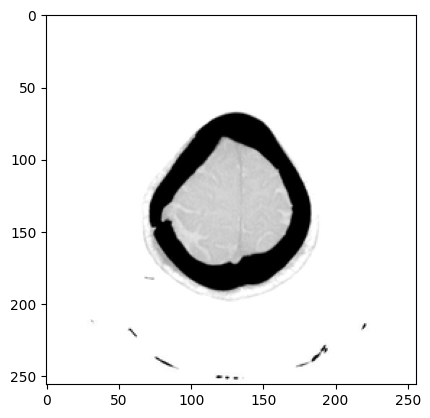

In [42]:
plt.imshow(NRM_train[0][:,:,1], cmap='binary')

# NRM_train[0][:, :, 0].shape

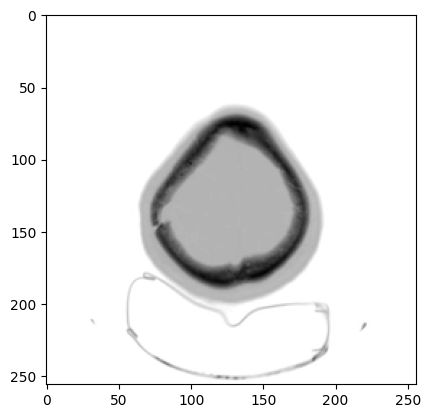

In [44]:
plt.imshow(NRM_train[0][:,:,1], cmap='binary')

In [32]:
# Load images for Epidural Hemorrhage

EDH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
EDH_label = []  # This will hold the labels


EDH_train_dict, EDH_label = main_loader(file_dir, windows, 1, EDH_train_dict, EDH_label, target_shape, None, EDH_valid_df)
EDH_train = stack_slices(EDH_train_dict)

sample = encoder.transform([[1]]).toarray()
labels = np.tile(sample, (len(EDH_train), 1))
# EDH_label = np.array(labels)

Loading images for brain_window...


Loading images from XN1 Data/renders/epidural/brain_window: 100%|██████████| 401/401 [00:01<00:00, 287.57file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/epidural/subdural_window: 100%|██████████| 401/401 [00:01<00:00, 295.26file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/epidural/brain_bone_window: 100%|██████████| 401/401 [00:01<00:00, 311.78file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 149796.57window/s]


In [33]:
# print(len(MCH_train_dict['brain_window']))
print(EDH_train.shape)
print(EDH_label.shape)

(401, 256, 256, 3)
(401, 7)


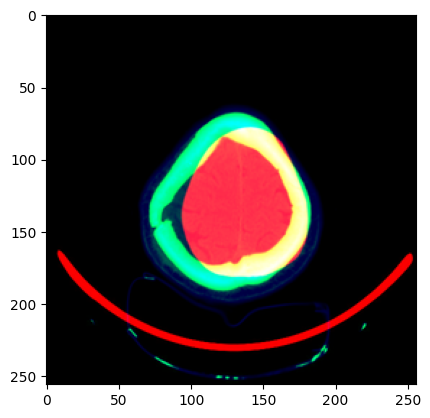

In [34]:
plt.imshow(NRM_train[0], cmap='binary')

In [35]:
# Load images for Subarachnoid Hemorrhage

SAH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
SAH_label = []  # This will hold the labels

SAH_train_dict, SAH_label = main_loader(file_dir, windows, 2, SAH_train_dict, SAH_label, target_shape, 4000, SAH_valid_df)

SAH_train = stack_slices(SAH_train_dict)

Loading images for brain_window...


Loading images from XN1 Data/renders/subarachnoid/brain_window: 100%|██████████| 389/389 [00:01<00:00, 295.75file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/subarachnoid/subdural_window: 100%|██████████| 389/389 [00:01<00:00, 298.90file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/subarachnoid/brain_bone_window: 100%|██████████| 389/389 [00:01<00:00, 319.22file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 42083.32window/s]


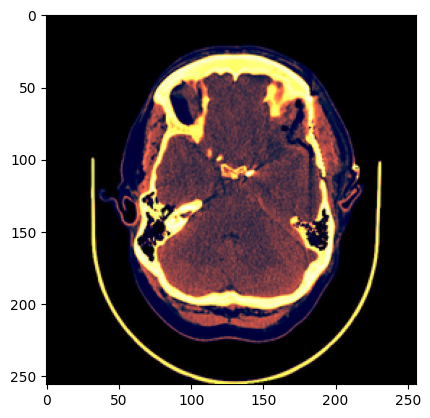

In [36]:
plt.imshow(SAH_train[0], cmap='binary')

In [37]:
# Load images for Intraparenchymal Hemorrhage

IPH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
IPH_label = []  # This will hold the labels

IPH_train_dict, IPH_label = main_loader(file_dir, windows, 3, IPH_train_dict, IPH_label, target_shape, 4000, IPH_valid_df)


IPH_train = stack_slices(IPH_train_dict)

Loading images for brain_window...


Loading images from XN1 Data/renders/intraparenchymal/brain_window: 100%|██████████| 640/640 [00:02<00:00, 291.57file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/intraparenchymal/subdural_window: 100%|██████████| 640/640 [00:02<00:00, 301.54file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/intraparenchymal/brain_bone_window: 100%|██████████| 640/640 [00:02<00:00, 300.50file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 165564.63window/s]


In [38]:
# Load images for Subdural Hemorrhage

SDH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
SDH_label = []  # This will hold the labels

SDH_train_dict, SDH_label = main_loader(file_dir, windows, 4, SDH_train_dict, SDH_label, target_shape, 4000, SDH_valid_df)


SDH_train = stack_slices(SDH_train_dict)

Loading images for brain_window...


Loading images from XN1 Data/renders/subdural/brain_window: 100%|██████████| 290/290 [00:01<00:00, 279.59file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/subdural/subdural_window: 100%|██████████| 290/290 [00:01<00:00, 285.56file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/subdural/brain_bone_window: 100%|██████████| 290/290 [00:00<00:00, 296.85file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 167772.16window/s]


In [39]:
# Load images for Intraventricular Hemorrhage

IVH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
IVH_label = []  # This will hold the labels

IVH_train_dict, IVH_label = main_loader(file_dir, windows, 5, IVH_train_dict, IVH_label, target_shape, 4000, IVH_valid_df)

IVH_train = stack_slices(IVH_train_dict)

Loading images for brain_window...


Loading images from XN1 Data/renders/intraventricular/brain_window: 100%|██████████| 1524/1524 [00:05<00:00, 301.91file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/intraventricular/subdural_window: 100%|██████████| 1524/1524 [00:05<00:00, 301.14file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/intraventricular/brain_bone_window: 100%|██████████| 1524/1524 [00:04<00:00, 313.13file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 93206.76window/s]


In [40]:
# Load images for Multiclass Hemorrhage

MCH_train_dict = {window: [] for window in windows}  # Create a dictionary to hold data for each window
MCH_label = []  # This will hold the labels

MCH_train_dict, MCH_label = main_loader(file_dir, windows, 6, MCH_train_dict, MCH_label, target_shape, 4000, MCH_valid_df)

MCH_train = stack_slices(MCH_train_dict)

Loading images for brain_window...


Loading images from XN1 Data/renders/multi/brain_window: 100%|██████████| 432/432 [00:01<00:00, 287.11file/s]


Loading images for subdural_window...


Loading images from XN1 Data/renders/multi/subdural_window: 100%|██████████| 432/432 [00:01<00:00, 299.19file/s]


Loading images for brain_bone_window...


Loading images from XN1 Data/renders/multi/brain_bone_window: 100%|██████████| 432/432 [00:01<00:00, 306.56file/s]


Converting lists to numpy arrays:


Stacking slices: 100%|██████████| 3/3 [00:00<00:00, 157286.40window/s]


In [16]:
# data_dict = {
#     "normal": NRM_train,
#     "epidural": EDH_train,
#     "subarachnoid": SAH_train,
#     "intraparenchymal": IPH_train,
#     "subdural": SDH_train,
#     "intraventricular": IVH_train,
#     "multi": MCH_train
# }
# 
# print(EDH_train.shape)
# print(EDH_label.shape)

In [45]:
X_train = np.concatenate((NRM_train, EDH_train, SAH_train, IPH_train, SDH_train, IVH_train, MCH_train), axis=0)
print(X_train.shape)
y_train = np.concatenate((NRM_label, EDH_label, SAH_label, IPH_label, SDH_label, IVH_label, MCH_label), axis=0)
print(y_train.shape)

(7476, 256, 256, 3)
(7476, 7)


In [46]:
X_train, y_train = shuffle(X_train, y_train)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [47]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(5980, 256, 256, 3)
(1496, 256, 256, 3)
(5980, 7)
(1496, 7)


In [2]:
keras.backend.clear_session()  # Clears the model
tf.__version__

NameError: name 'keras' is not defined

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.__version__

Num GPUs Available:  0


'2.18.0'

In [ ]:
from tensorflow.keras import layers

def se_block(input_tensor, reduction=16):
    """Squeeze-and-Excitation block."""
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.multiply([input_tensor, se])

In [ ]:
def resnext_block(input_tensor, filters, cardinality=32, strides=1):
    """ResNeXt block with SE."""
    group_channels = filters // cardinality
    
    # Grouped Convolution
    conv_list = []
    for i in range(cardinality):
        x = layers.Conv2D(group_channels, (1, 1), strides=strides, padding='same')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(group_channels, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        conv_list.append(x)
    
    # Concatenate grouped convolutions
    x = layers.Concatenate()(conv_list)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # SE Block
    x = se_block(x)

    # Add residual connection if possible
    if input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides)(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
from tensorflow.keras import Model, Input

def build_se_resnext101(input_shape=(256, 256, 3), num_classes=1000):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual Blocks with SE blocks
    filters = 64
    for stack in [3, 4, 23, 3]:  # Following ResNeXt101 depth
        for i in range(stack):
            strides = 2 if i == 0 and filters != 64 else 1
            x = resnext_block(x, filters, cardinality=32, strides=strides)
        filters *= 2  # Increase filters per stack
    
    # Pooling and Final Dense Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

In [ ]:
# Define model
model = build_se_resnext101(input_shape=(256, 256, 3), num_classes=7)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train
# model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

In [54]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers, models, optimizers, callbacks, losses, regularizers

# Function to build DenseNet models with custom input shapes
def build_densenet(model_type="densenet169", input_shape=(256, 256, 3), num_classes=7):

    base_model = DenseNet169(weights="imagenet", include_top=False, input_shape=input_shape)
    
    # # Freeze the base model layers
    # base_model.trainable = False
    # 
    # unfreeze top few layers of densenet, for more personalized training
    for layer in base_model.layers[:5]:
        layer.trainable = True

    # Add custom layers on top
    model = models.Sequential([
        base_model,
        
        # Global Average Pooling (to reduce dimensionality)
        layers.GlobalAveragePooling2D(),
        # layers.BatchNormalization(),
        
        layers.Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        # layers.Dropout(0.4),
        
        # Output layer for classification
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")  # softmax activation for multi-label classification
])
    return model

# Compile function
def compile_model(model):
    # AdamW optimizer with weight decay
    optimizer = optimizers.AdamW(learning_rate=0.00001, weight_decay=3e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Build and compile the DenseNet model
densenet169_model = compile_model(build_densenet("densenet169", input_shape=(256, 256, 3), num_classes=7))

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create the train and validation generators using numpy arrays
train_generator = train_datagen.flow(
    X_train, 
    y_train, 
    batch_size=32
)

val_generator = val_datagen.flow(
    X_valid, 
    y_valid, 
    batch_size=32
)

# Learning rate scheduler with warm restarts
scheduler = callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=0.00001,
        first_decay_steps=5 * len(X_train) // 32,
        t_mul=1.0,
        alpha=1e-5
    )
)

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = densenet169_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_generator,
    validation_steps=len(X_valid) // 32,
    epochs=40,
    callbacks=[scheduler, early_stopping]
)

Epoch 1/40
186/186 [==============================] - 329s 2s/step - loss: 25.6515 - accuracy: 0.5740 - val_loss: 24.1948 - val_accuracy: 0.7283 - lr: 1.0000e-05
Epoch 2/40
186/186 [==============================] - 274s 1s/step - loss: 23.3389 - accuracy: 0.7154 - val_loss: 22.2831 - val_accuracy: 0.7588 - lr: 1.0000e-05
Epoch 3/40
186/186 [==============================] - 276s 1s/step - loss: 21.4978 - accuracy: 0.7342 - val_loss: 20.5775 - val_accuracy: 0.7534 - lr: 9.9999e-06
Epoch 4/40
186/186 [==============================] - 273s 1s/step - loss: 19.8118 - accuracy: 0.7554 - val_loss: 18.9977 - val_accuracy: 0.7779 - lr: 9.9997e-06
Epoch 5/40
186/186 [==============================] - 271s 1s/step - loss: 18.2838 - accuracy: 0.7808 - val_loss: 17.5865 - val_accuracy: 0.7772 - lr: 9.9995e-06
Epoch 6/40
186/186 [==============================] - 273s 1s/step - loss: 16.8812 - accuracy: 0.7919 - val_loss: 16.2387 - val_accuracy: 0.7840 - lr: 9.9993e-06
Epoch 7/40
186/186 [========

In [ ]:
### EVALUATE AND FINE TUNE

# Unfreeze some layers in DenseNet169 for fine-tuning
for layer in densenet169_model.layers[0].layers[-30:]:  # Adjust based on layer count
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
densenet169_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

# Fine-tune
fine_tune_history = densenet169_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20
)

In [ ]:
# optimizer=legacy.Adam(learning_rate=1e-2)
# 
# model.compile(loss="categorical_crossentropy",
#               optimizer=optimizer,
#               metrics=["accuracy"])

In [ ]:
model.fit(X_train, y_train, batch_size=32, validation_data=(X_valid, y_valid), epochs=50)
# historysgd = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), class_weight=class_weight_dict)

In [2]:
import pandas as pd

data = [
    [0.5740, 0.7283, 25.6515, 24.1948],
    [0.7154, 0.7588, 23.3389, 22.2831],
    [0.7342, 0.7534, 21.4978, 20.5775],
    [0.7554, 0.7779, 19.8118, 18.9977],
    [0.7808, 0.7772, 18.2838, 17.5865],
    [0.7919, 0.7840, 16.8812, 16.2387],
    [0.8021, 0.7976, 15.6103, 15.0385],
    [0.8252, 0.8071, 14.4112, 13.9292],
    [0.8364, 0.8193, 13.3386, 12.8926],
    [0.8480, 0.8322, 12.3601, 11.9468],
    [0.8625, 0.8240, 11.4417, 11.1364],
    [0.8700, 0.8471, 10.6188, 10.3243],
    [0.8826, 0.8444, 9.8562, 9.6223],
    [0.8912, 0.8553, 9.1579, 8.9587],
    [0.9020, 0.8533, 8.5264, 8.3926],
    [0.9084, 0.8485, 7.9364, 7.8782],
    [0.9232, 0.8607, 7.4084, 7.3535],
    [0.9232, 0.8757, 6.9249, 6.8885],
    [0.9279, 0.8730, 6.4874, 6.4826],
    [0.9398, 0.8736, 6.0689, 6.1140],
    [0.9386, 0.8723, 5.7168, 5.7834],
    [0.9472, 0.8770, 5.3647, 5.4704],
    [0.9528, 0.8750, 5.0582, 5.2180],
    [0.9474, 0.8852, 4.7974, 4.9228],
    [0.9565, 0.8886, 4.5219, 4.6678],
    [0.9602, 0.8879, 4.2846, 4.4596],
    [0.9617, 0.8933, 4.0643, 4.2686],
    [0.9694, 0.8906, 3.8524, 4.0874],
    [0.9704, 0.8845, 3.6702, 3.9279],
    [0.9707, 0.8886, 3.4942, 3.7736],
    [0.9702, 0.8988, 3.3342, 3.5854],
    [0.9792, 0.8927, 3.1707, 3.4703],
    [0.9793, 0.8933, 3.0257, 3.3517],
    [0.9792, 0.8995, 2.8903, 3.1951],
    [0.9776, 0.9015, 2.7654, 3.0630],
    [0.9817, 0.9022, 2.6320, 2.9493],
    [0.9830, 0.8988, 2.5094, 2.8800],
    [0.9869, 0.9042, 2.3923, 2.7765],
    [0.9866, 0.8988, 2.2845, 2.6890],
    [0.9862, 0.8981, 2.1787, 2.5669],
]

df = pd.DataFrame(data, columns=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

print(df)

    accuracy  val_accuracy     loss  val_loss
0     0.5740        0.7283  25.6515   24.1948
1     0.7154        0.7588  23.3389   22.2831
2     0.7342        0.7534  21.4978   20.5775
3     0.7554        0.7779  19.8118   18.9977
4     0.7808        0.7772  18.2838   17.5865
5     0.7919        0.7840  16.8812   16.2387
6     0.8021        0.7976  15.6103   15.0385
7     0.8252        0.8071  14.4112   13.9292
8     0.8364        0.8193  13.3386   12.8926
9     0.8480        0.8322  12.3601   11.9468
10    0.8625        0.8240  11.4417   11.1364
11    0.8700        0.8471  10.6188   10.3243
12    0.8826        0.8444   9.8562    9.6223
13    0.8912        0.8553   9.1579    8.9587
14    0.9020        0.8533   8.5264    8.3926
15    0.9084        0.8485   7.9364    7.8782
16    0.9232        0.8607   7.4084    7.3535
17    0.9232        0.8757   6.9249    6.8885
18    0.9279        0.8730   6.4874    6.4826
19    0.9398        0.8736   6.0689    6.1140
20    0.9386        0.8723   5.716

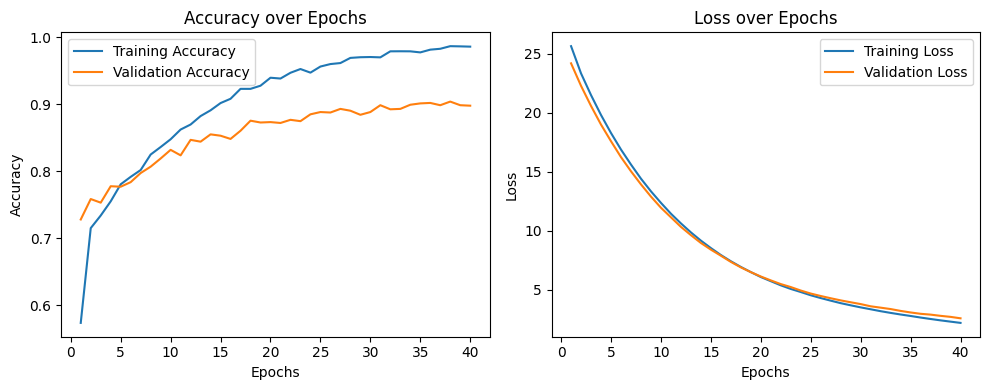

In [4]:
import matplotlib.pyplot as plt

# Assuming df is the pandas DataFrame
epochs = range(1, len(df) + 1)

# Set the figure size to emphasize horizontal width
plt.figure(figsize=(10, 4))  # Increase width, reduce height for horizontal orientation

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, df['accuracy'], label='Training Accuracy')
plt.plot(epochs, df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, df['loss'], label='Training Loss')
plt.plot(epochs, df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Adjust layout for better spacing and display
plt.tight_layout()
plt.show()